<center>
<a href="http://uf-mi.u-bordeaux.fr/MSS/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/logo_MAS_MSS.jpg" style="float:left; max-width: 400px; display: inline" alt="INSA"/></a>

<a href="https://www.math.u-bordeaux.fr/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/LogoIMB.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 200px; display: inline" alt="Python"/></a> UE M2 Master MAS-MSS et CIMI ISI Projet Données Massives

# Groupe de Moussa NGAMBE & Mahamadou Ousmane KEITA

# Classification d'images avec des réseaux de neurons profonds
<a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 150px; display: inline" alt="Python"/></a> & <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 180px; display: inline" alt="Scikit-Learn"/></a>


**Résumé**: Ce calepin propose l'utilisation des librairies `keras` et `tensorflow` pour l'implémentation de modèles de réseaux de neurones profond pour une tâche d'apprentissage supervisé à $K=2$ en traitement d'images.

Vous allez devoir implémenter ces algorithmes en grande dimension sur un problème de classification d'images couleurs de taille $128 \times 128$ (présence ou non d'une éolienne dans des images satellites) et comparer leurs performances.

Les données sont partagées en un ensemble d'apprentissage où pour chaque image vous connaissez sa classe (présence ou non d'une éolienne) et un ensemble de test (ensemble d'images non-labellisée) surlequel seront evaluées les performances de votre meilleure méthode à la fin du projet.

Vous pouvez télécharger les données liées à ce projet à cette adresse :

https://filesender.renater.fr/?s=download&token=8719d9aa-8beb-4af8-94ed-62582dd0764c

Les attendus du projet sont :

- un court compte-rendu qui présente le meilleur modèle que vous avez obtenu et sa validation à l'aide des données d'apprentissage,

- un fichier .csv qui contient les prédictions des classes pour les images de l'ensemble test à partir duquel un taux de bonne classification sera calculé en fin de projet.

Dans ce travail, vous pouvez créer vos propres architectures de réseaux de neurons, mais également utiliser des modèles pré-entraînés sur d'autres bases de données et les adapter à la problématique de classification d'images de ce projet. Un dictacticiel à ce sujet est disponible ici :

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=fr

## 1. Traitement des données

### 1.1. Importation

In [1]:
# Importation de librairies
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.preprocessing.image as kpi

Les images se trouvent dans la base train, validation et test. La base test est la seule des bases ou l'ont n'a pas les labes de nos images ce qui fait qu'on ne va pas les manipuler.

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount("/content/drive")

from zipfile import ZipFile as zf
data = zf('/content/drive/MyDrive/Data_Projet_TP3_Defi_IA.zip', 'r')
data.extractall()
data.close

Mounted at /content/drive


<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/Data_Projet_TP3_Defi_IA.zip' mode='r'>>

In [4]:
# Chemin d'accès aux données
data_dir = '/content/Data_Projet_TP3_Defi_IA'
# Paramètres
nb_classes = 2
batch_size=100

# Taille des images
img_width = 128
img_height = 128

# Définition d'un générateur qui lira les images trouvées dans
# les sous-dossiers de data_dir+'/train', et génère indéfiniment
# des lots (batch) de données d'images
train_generator = kpi.ImageDataGenerator().flow_from_directory(
        data_dir+"/train/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# Ceci est un générateur similaire, pour des données de validation
validation_generator = kpi.ImageDataGenerator().flow_from_directory(
        data_dir+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

Found 58218 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### 1.2. Augmentation des données

Ne disposant que de 58218 images pour l'apprentissage de notre algorithme, nous avons décider d'augmenter artificiellement nos données en faisant des modifications sur nos images.

Nos modifications se feront via la sequence ci-dessous et les modifications apportées aux images seront des retournements, des rotations, des changements de la luminosité, des zooms et des changements de contraste.

In [5]:
#Augmentation'artificielle' des données plus graphiques
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(1),
  tf.keras.layers.RandomBrightness(0.2),
  tf.keras.layers.RandomZoom(height_factor=(0.1)),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation(0.1,0.1)])

Nous allons illustrer nos choix via l'exemple de l'image ci-dessous

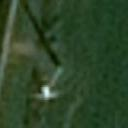

In [6]:
img = kpi.load_img(data_dir+'/train/target/C81820872.jpg')
img

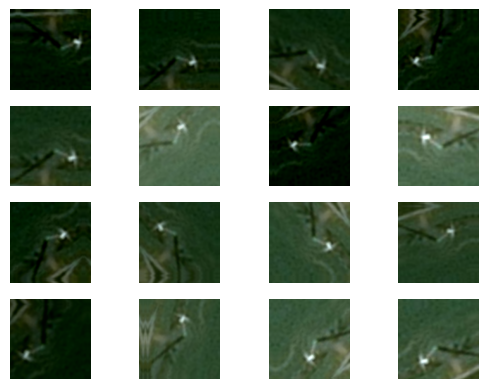

In [7]:
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(img, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

A noté que nos paramètres pour nos modifications ont été ajusté pour qu'à l'oeil nu, nous puissions distinguées la présence d'héolienne ou non sur nos images toutes en maximisant les possibilités.

## 2. Modèles

Puis que nous devons donner nos deux meilleurs modèles, dans cette partie nous allons les compiler, entrainer et ajuster en fonction des performances.

Le prémier modèle que nous allons exploiter est le MobileNET.

Le modèle MobileNet est conçu pour les environments à ressources limité comme les téléphones mobiles. Il utilise la couche de convolution depth-wise separable pour reduire le cout de calcul tout en maintenant la précision, faisant de lui un modèle de reconnaissance d'images en temps réel idéal pour machines à ressources limités.

Le deuxième modèle que nous allons exploiter est le modèle Efficient NET

Le modèle EfficientNet est les des modèles les plus efficaces (i.e. nécessitant le moins de FLOPS pour l'inférence) qui atteint une précision de pointe sur les tâches d'apprentissage par transfert d'imagenet et de classification d'images courantes.

### 2.1. Modèle Mobile Net

### 2.1.1. Compilation

Le Mobile Net utilise des images ayant des pixels entre $-1$ et $1$ ce qui n'est pas la cas de nos images.

Nous allons donc procéder à un pré-traitement des données via la couche ci-dessous.

In [8]:
# Prétraitement des données pour l'I.A Mobile NET
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

Maintenant, il nous faut importer le modèle.

In [9]:
# Modèle de base
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')

12683000/12683000 [==============================] - 0s 0us/step


Après plusieurs test sur le fine-tuning de ce modèle, nous avons conclue que le meilleur moyen d'optimiser ce modèle pour notre problème est d'entrainer toutes les couches.

In [10]:
# On dégèle les couches du modèle pour entrainer les paramètres
base_model.trainable = True
#base_model.summary()

Nous allons changer la tête de classification pour l'adaper à notre cas de classification binaire, tout en ajoutant une couche de GlobalAveragePooling2D pour réduire le temps de calcul.

In [11]:
# Tête de Classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Cette servira à réduire le temps de calcul
prediction_layer = tf.keras.layers.Dense(2,activation="relu")
inputs = tf.keras.Input(shape=(img_width, img_height, 3))

Il ne reste plus qu'a compilier le modèle.

Pour se faire, nous avons choisit un $learning \ rate \ de \ 0.0001$ (après plusieurs tests) qui nous semblait être optimal en terme de précision et de temps de calcul.

Nous n'avons également pas pris en compte des couches de dropout car après plusieurs essaies, on obtenait des résultats similaires avec ou sans ces couches et cela en ajustant simplement le nombre d'epochs.

In [12]:
x = data_augmentation(inputs) # Cette couche nous sert à augmenter artificiellement nos données

x = preprocess_input(x) # Cette couche sert à traiter les données pour les utiliser dans notre modèle

x = base_model(x) # le mobile net V3

x = global_average_layer(x) # La couche de GlobalAveragePooling2D pour la reduction du temps de calcul

outputs = prediction_layer(x) # La couche de prédiction

x = tf.keras.layers.Dropout(0.05)(x) # Pour éviter d'éventuel sur apprentissage
                                    # et renforcer la robustesse des couches

model_mobile_net = tf.keras.Model(inputs, outputs) # Le modèle

# Compilation du modèle
base_learning_rate = 0.0001
model_mobile_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

#model_mobile_net.summary() #Pour jeter un oeil au nouveau modèle

### 2.1.2. Entrainement

In [13]:
epochs = 10

history_mobile_net = model_mobile_net.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

Epoch 1/10
583/583 [==============================] - 144s 175ms/step - loss: 0.4218 - accuracy: 0.9366 - val_loss: 0.4317 - val_accuracy: 0.9460
Epoch 2/10
583/583 [==============================] - 100s 171ms/step - loss: 0.3897 - accuracy: 0.9684 - val_loss: 0.3996 - val_accuracy: 0.9598
Epoch 3/10
583/583 [==============================] - 99s 169ms/step - loss: 0.3854 - accuracy: 0.9720 - val_loss: 0.3952 - val_accuracy: 0.9631
Epoch 4/10
583/583 [==============================] - 99s 169ms/step - loss: 0.3827 - accuracy: 0.9736 - val_loss: 0.3932 - val_accuracy: 0.9685
Epoch 5/10
583/583 [==============================] - 98s 169ms/step - loss: 0.3800 - accuracy: 0.9749 - val_loss: 0.3940 - val_accuracy: 0.9682
Epoch 6/10
583/583 [==============================] - 98s 168ms/step - loss: 0.3778 - accuracy: 0.9769 - val_loss: 0.3870 - val_accuracy: 0.9739
Epoch 7/10
583/583 [==============================] - 98s 168ms/step - loss: 0.3774 - accuracy: 0.9775 - val_loss: 0.3882 - val_

Réprésentation Graphique de l'entrainement

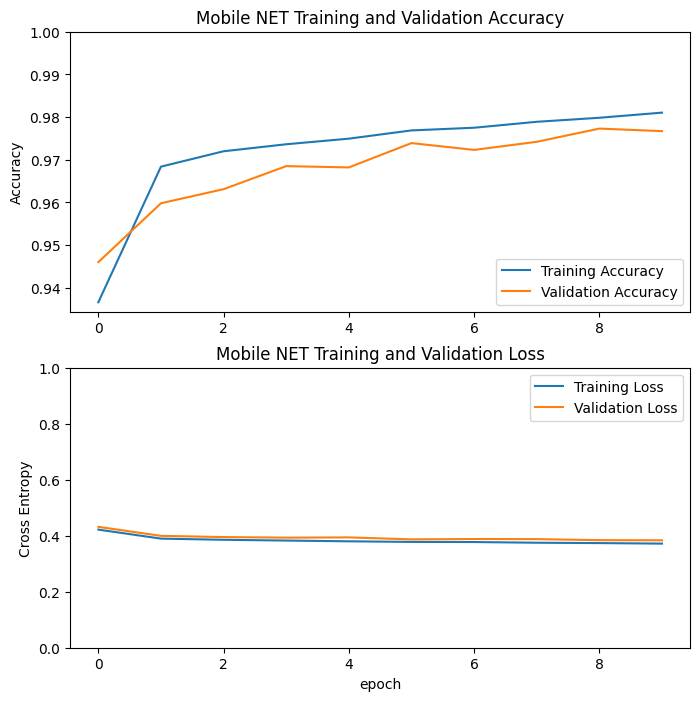

In [14]:
# Graphique des performances en fonction des epochs
acc = history_mobile_net.history['accuracy']
val_acc = history_mobile_net.history['val_accuracy']

loss = history_mobile_net.history['loss']
val_loss = history_mobile_net.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Mobile NET Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Mobile NET Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 2.2. Efficient NET

### 2.2.1. Compilation

Ici, on va procéder de la même manière que le modèle mobile net à la différence qu'ici nous allons géler les couches du modèle.

In [15]:
from tensorflow.keras.applications import EfficientNetB4

In [16]:
inputs =  tf.keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)

model = EfficientNetB4(include_top=False,
                        input_tensor=x,
                        weights="imagenet")

# Dégèle les parramètres pré-entrainé
model.trainable = True

# Réconstruit le tête
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
outputs = tf.keras.layers.Dense(nb_classes, activation="softmax", name="pred")(x)

x = tf.keras.layers.Dropout(0.05)(x) # Pour éviter d'éventuel sur apprentissage

# Compilation
model_Efficient_NET = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model_Efficient_NET.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
#model_Efficient_NET.summary()

### 2.2.2. Entrainement

In [17]:
epochs = 10

history_Efficient_NET = model_Efficient_NET.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

Epoch 1/10
583/583 [==============================] - 480s 699ms/step - loss: 0.1252 - accuracy: 0.9534 - val_loss: 0.0849 - val_accuracy: 0.9694
Epoch 2/10
583/583 [==============================] - 405s 695ms/step - loss: 0.0803 - accuracy: 0.9725 - val_loss: 0.0779 - val_accuracy: 0.9754
Epoch 3/10
583/583 [==============================] - 402s 690ms/step - loss: 0.0726 - accuracy: 0.9754 - val_loss: 0.0772 - val_accuracy: 0.9736
Epoch 4/10
583/583 [==============================] - 403s 691ms/step - loss: 0.0657 - accuracy: 0.9769 - val_loss: 0.0798 - val_accuracy: 0.9744
Epoch 5/10
583/583 [==============================] - 405s 695ms/step - loss: 0.0601 - accuracy: 0.9790 - val_loss: 0.0742 - val_accuracy: 0.9748
Epoch 6/10
583/583 [==============================] - 405s 695ms/step - loss: 0.0583 - accuracy: 0.9794 - val_loss: 0.0732 - val_accuracy: 0.9774
Epoch 7/10
583/583 [==============================] - 401s 688ms/step - loss: 0.0528 - accuracy: 0.9813 - val_loss: 0.0747 -

Representation Graphique des resultats

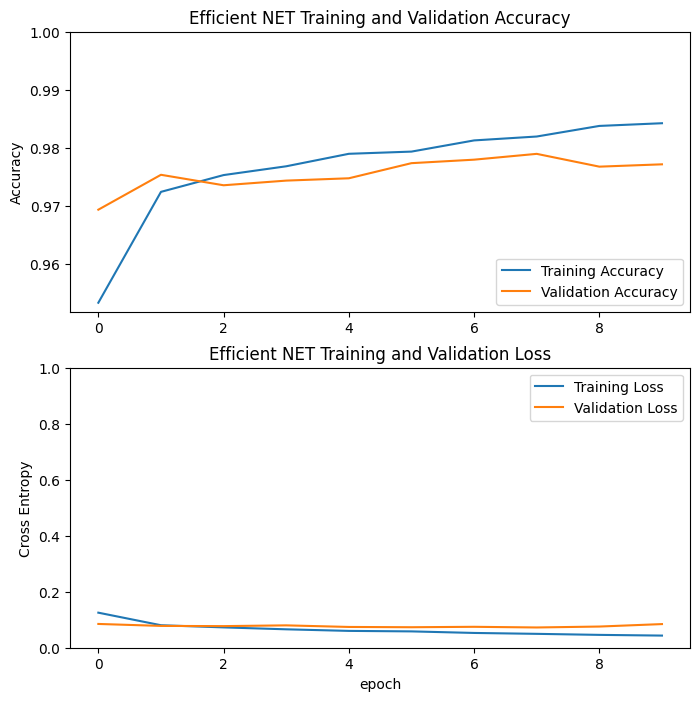

In [18]:
# Graphique des performances en fonction des epochs
acc = history_Efficient_NET.history['accuracy']
val_acc = history_Efficient_NET.history['val_accuracy']

loss = history_Efficient_NET.history['loss']
val_loss = history_Efficient_NET.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Efficient NET Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Efficient NET Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 3. Renforcement des modèles

Compte tenu du fait que nos modèles ne progressent que très peu avec les données d'apprentissages. Nous allons intervertir les rôles des deux jeux de données pour tirer de l'informations des données de validation

## 3.1. Mobile net

In [20]:
epochs = 5

history_mobile_net = model_mobile_net.fit(validation_generator,
                    epochs=epochs,
                    validation_data=train_generator)

Epoch 1/5
50/50 [==============================] - 49s 997ms/step - loss: 0.3865 - accuracy: 0.9705 - val_loss: 0.3710 - val_accuracy: 0.9817
Epoch 2/5
50/50 [==============================] - 48s 979ms/step - loss: 0.3799 - accuracy: 0.9770 - val_loss: 0.3729 - val_accuracy: 0.9800
Epoch 3/5
50/50 [==============================] - 50s 1s/step - loss: 0.3740 - accuracy: 0.9799 - val_loss: 0.3756 - val_accuracy: 0.9787
Epoch 4/5
50/50 [==============================] - 48s 974ms/step - loss: 0.3728 - accuracy: 0.9777 - val_loss: 0.3773 - val_accuracy: 0.9768
Epoch 5/5
50/50 [==============================] - 47s 944ms/step - loss: 0.3689 - accuracy: 0.9820 - val_loss: 0.3755 - val_accuracy: 0.9785


Répresentations graphiques des résultats

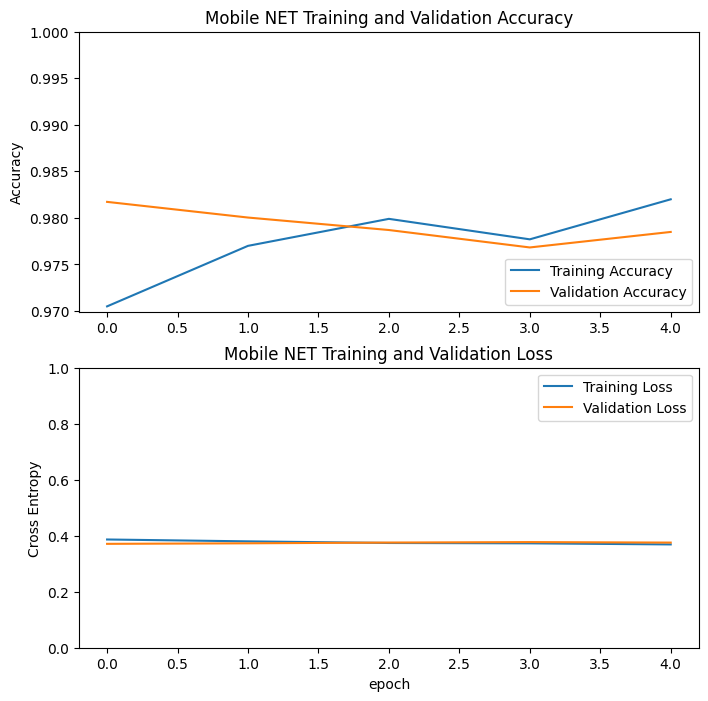

In [22]:
# Graphique des performances en fonction des epochs
acc = history_mobile_net.history['accuracy']
val_acc = history_mobile_net.history['val_accuracy']

loss = history_mobile_net.history['loss']
val_loss = history_mobile_net.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Mobile NET Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Mobile NET Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Avec cette méthode, on fait légèrement mieux.

## 3.2. Efficient net

In [21]:
epochs = 5

history_Efficient_NET = model_Efficient_NET.fit(validation_generator,
                    epochs=epochs,
                    validation_data=train_generator)

Epoch 1/5
50/50 [==============================] - 175s 4s/step - loss: 0.0689 - accuracy: 0.9766 - val_loss: 0.0328 - val_accuracy: 0.9881
Epoch 2/5
50/50 [==============================] - 124s 3s/step - loss: 0.0589 - accuracy: 0.9800 - val_loss: 0.0346 - val_accuracy: 0.9872
Epoch 3/5
50/50 [==============================] - 176s 4s/step - loss: 0.0456 - accuracy: 0.9834 - val_loss: 0.0391 - val_accuracy: 0.9853
Epoch 4/5
50/50 [==============================] - 124s 3s/step - loss: 0.0418 - accuracy: 0.9846 - val_loss: 0.0364 - val_accuracy: 0.9863
Epoch 5/5
50/50 [==============================] - 125s 3s/step - loss: 0.0365 - accuracy: 0.9864 - val_loss: 0.0366 - val_accuracy: 0.9863


Répresentations graphiques des résultats

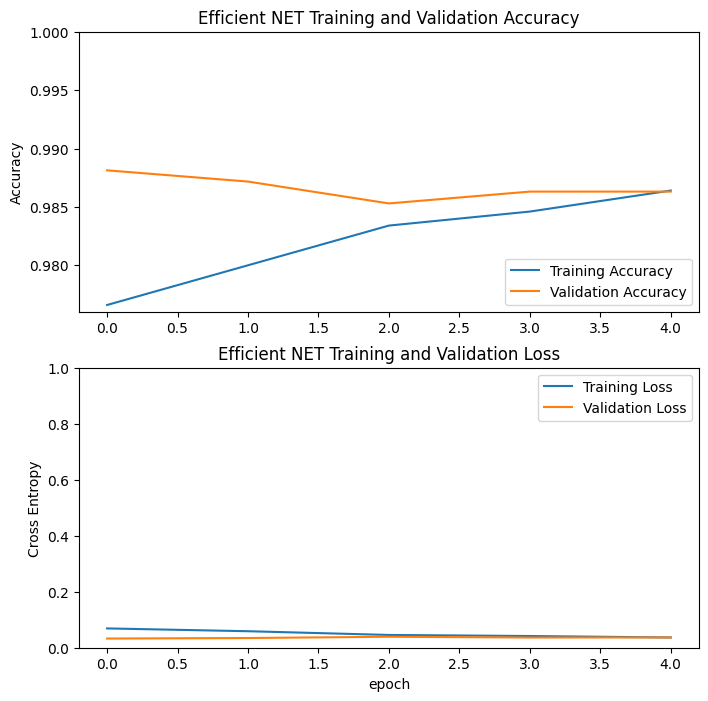

In [23]:
# Graphique des performances en fonction des epochs
acc = history_Efficient_NET.history['accuracy']
val_acc = history_Efficient_NET.history['val_accuracy']

loss = history_Efficient_NET.history['loss']
val_loss = history_Efficient_NET.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Efficient NET Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Efficient NET Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Avec cette méthode, on fait légèrement mieux.

## 4. Prédictions et Fichier CSV

### Importation des données

In [24]:
# Calcul des predictions pour chaque image sur l'ensemble de test
prediction_dir = data_dir+"/test/"

# this is a similar generator, for test data
test_generator = kpi.ImageDataGenerator().flow_from_directory(
        prediction_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode=None,
        shuffle=False)

test_generator.reset()

Found 5000 images belonging to 1 classes.


### 4.1. Mobile NET

In [25]:
pred_test_mobile_net = model_mobile_net.predict(test_generator,verbose=1)

5000/5000 [==============================] - 47s 9ms/step


In [26]:
test_predictions_mobile_net = pd.read_csv(data_dir+'/template_predictions.csv', sep=";")

res = np.sort(test_predictions_mobile_net["name"])

pos = np.argsort(test_predictions_mobile_net["name"])

test_predictions_mobile_net["prediction"][pos] = pred_test_mobile_net.argmax(axis=-1)

test_predictions_mobile_net.to_csv(data_dir+'/reg_logistic_predictions_mobile_net.csv', index=False)

## 4.2. Efficient NET

In [27]:
pred_test_Efficient_NET = model_Efficient_NET.predict(test_generator,verbose=1)

5000/5000 [==============================] - 102s 20ms/step


In [28]:
test_predictions__Efficient_NET = pd.read_csv(data_dir+'/template_predictions.csv', sep=";")

res = np.sort(test_predictions__Efficient_NET["name"])

pos = np.argsort(test_predictions__Efficient_NET["name"])

test_predictions__Efficient_NET["prediction"][pos] = pred_test_Efficient_NET.argmax(axis=-1)

test_predictions__Efficient_NET.to_csv(data_dir+'/reg_logistic_predictions_Efficient_NET.csv', index=False)